In [1]:
from configs.default import _C as config
from configs.default import update_config

from datasets import flickr8k_parse
from nltk.translate.bleu_score import corpus_bleu
from scipy import misc

from models import decoder, image_preprocessing, predict, transfer_models

import matplotlib.pyplot as plt
import math
import numpy as np
import os
import path_generation
import text_processing

from PIL import Image

import scipy as sc

Using TensorFlow backend.


In [2]:
config_file = "./configs/attn.yaml"
update_config(config, config_file) # config is imported from default.py _C above
# most parameters are in default.py, parameters in attn.yaml overwrite these defaults

# Evaluation for models built on Flickr8k

In [3]:
train_vocab = text_processing.Vocabulary()
word_to_id_path = os.path.join(config.PATH.VOCABULARY_PATH, config.VOCABULARY.WORD_TO_ID)
id_to_word_path = os.path.join(config.PATH.VOCABULARY_PATH, config.VOCABULARY.ID_TO_WORD)
count_path = os.path.join(config.PATH.VOCABULARY_PATH, config.VOCABULARY.COUNT)
train_vocab.load_vocabulary(word_to_id_path, id_to_word_path, count_path)

In [4]:
path_gen = path_generation.PathGenerator(config.DECODER.GRU, 
                                         config.DATASET, 
                                         config.DECODER.NUM_RNN_LAYERS, 
                                         config.DECODER.BATCH_SIZE, 
                                         config.DECODER.BATCH_NORM, 
                                         config.DECODER.DROPOUT, 
                                         config.ATTENTION, 
                                         config.DECODER.ATTN_TYPE)

path_checkpoint = path_gen.get_weights_path()
model_path = path_gen.get_model_path()
captions_path = path_gen.get_captions_path()
print("path_checkpoint",path_checkpoint,"\n model_path",model_path, \
     " \n captions_path",captions_path)

path_checkpoint ./model_files/weights/VGG16_LSTM_Flickr8k_2l_32b_bn_dr_attn_bahdanau.hdf5 
 model_path ./model_files/models/VGG16_LSTM_2l_bn_dr_attn_bahdanau.json  
 captions_path ./model_files/captions/VGG16_LSTM_Flickr8k_2l_32b_bn_dr_attn_bahdanau_3b.txt


In [5]:
if config.ATTENTION:
    transfer_values = np.load(os.path.join(config.PATH.FEATURES_PATH, 'vgg16_flickr8k_train_attn.npy'))
    val_transfer_values = np.load(os.path.join(config.PATH.FEATURES_PATH, 'vgg16_flickr8k_val_attn.npy'))
else:
    transfer_values = np.load(os.path.join(config.PATH.FEATURES_PATH, 'vgg16_flickr8k_train.npy'))
    val_transfer_values = np.load(os.path.join(config.PATH.FEATURES_PATH, 'vgg16_flickr8k_val.npy'))

In [6]:
decoder_model = decoder.load_model(model_path, path_checkpoint)

model_path ./model_files/models/VGG16_LSTM_2l_bn_dr_attn_bahdanau.json 
 weights_path ./model_files/weights/VGG16_LSTM_Flickr8k_2l_32b_bn_dr_attn_bahdanau.hdf5 





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








In [7]:
VGG_transfer_model, VGG_image_size = transfer_models.vgg_model(config.ATTENTION)
# VGG_transfer_model2, VGG_image_size2 = transfer_models.vgg_model2(config.ATTENTION)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________

i00 0 path0 assault0.jpg
i00 0 path0 C:/Users/MStopa/ImageCaptioning/datasets/MyImages/security/assault0.jpg
input_transfer_values.shape (1, 14, 14, 512)
output_transfer_values.shape (1, 512)
captions [[[1, 2, 105, 48, 2, 95, 317, 65, 110, 10, 119, 12], -0.6685535348951817], [[1, 2, 105, 48, 2, 95, 317, 65, 110, 2, 119, 12], -0.8861339775224527], [[1, 2, 105, 48, 2, 95, 317, 65, 110, 2, 480, 12], -0.896646880855163]]
TV.shape (1, 512)
i00 1 path0 assault1.jpg
i00 1 path0 C:/Users/MStopa/ImageCaptioning/datasets/MyImages/security/assault1.jpg
input_transfer_values.shape (1, 14, 14, 512)
output_transfer_values.shape (1, 512)
captions [[[1, 2, 105, 69, 2, 97, 61, 5, 89, 2, 91, 12], -1.4037203354140122], [[1, 2, 105, 69, 2, 97, 61, 48, 134, 5, 89, 2, 91, 12], -1.6034131584068139], [[1, 2, 105, 69, 2, 97, 61, 48, 134, 5, 89, 2, 91, 72, 2, 327, 104, 12], -2.1897143634657064]]
TV.shape (1, 512)
i00 2 path0 assault2.jpg
i00 2 path0 C:/Users/MStopa/ImageCaptioning/datasets/MyImages/security/ass

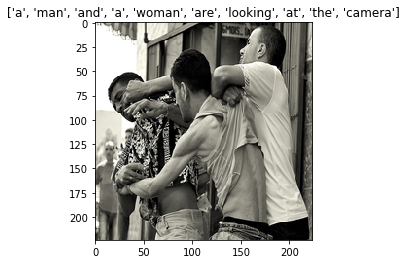

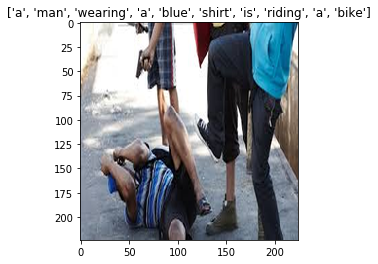

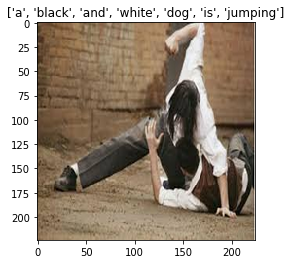

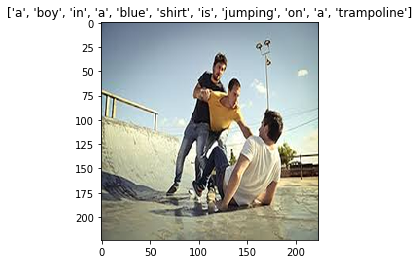

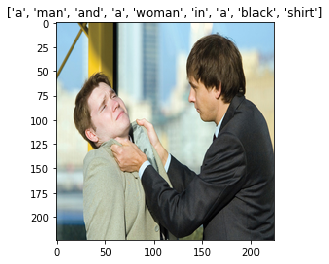

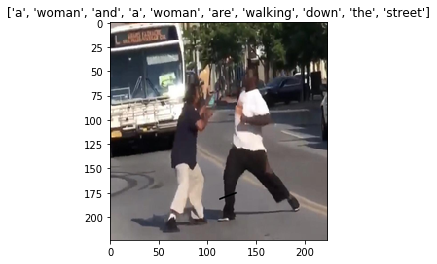

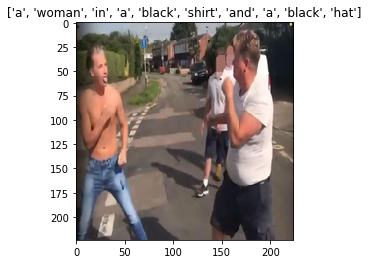

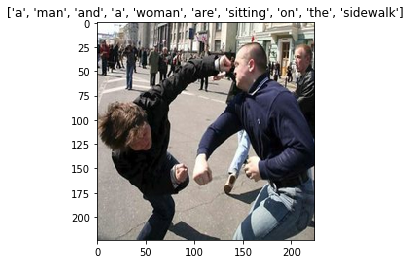

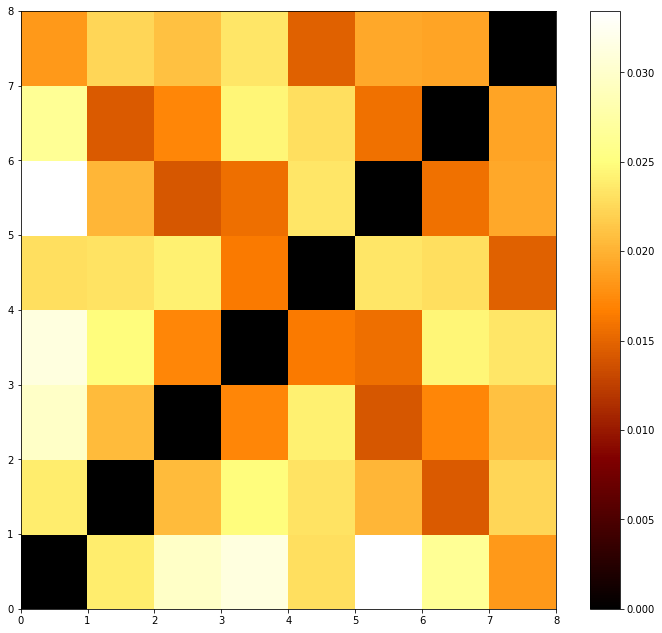

In [ ]:
### beam size might be changed here
beam_size = 3
if config.ATTENTION:
    get_weights = True
else:
    get_weights = False

# captions file - all images
# captions_file = os.path.join(config.PATH.ANNOTATIONS_PATH, "Flickr8k.token.txt")
# test image names
# test_txt_path = os.path.join(config.PATH.ANNOTATIONS_PATH, "Flickr_8k.testImages.txt")
# 
# filenames_with_all_captions = \ 
# flickr8k_parse.generate_filenames_with_all_captions(captions_file,config.PATH.IMG_PATH)
# test filenames with all captions
# test_filenames_with_all_captions = \
# flickr8k_parse.generate_set(test_txt_path,filenames_with_all_captions,config.PATH.IMG_PATH)

file1="C:/Users/MStopa/ImageCaptioning/datasets/MyImages/security/assault_files.txt"
# file1="C:/Users/MStopa/ImageCaptioning/datasets/MyImages/racecar_files.txt"
#file1="C:/Users/MStopa/ImageCaptioning/datasets/Flickr8k/annotations/Flickr_8k.testImages.txt"
# file1="C:/Users/MStopa/ImageCaptioning/datasets/MyImages/brown_dog_files.txt"
with open (file1, "r") as test_files:
    t_files=test_files.read().splitlines()

n_images=8
n_start=0
TVa=np.zeros((n_images,512))
distance=np.zeros((n_images,n_images))
for i00 in range (n_start,n_start+n_images):
    i01=i00-n_start
    path0=t_files[i00]
    print("i00",i00,"path0",path0)
#    path0='C:/Users/MStopa/ImageCaptioning/datasets/Flickr8k/Images/' + path0
    path0='C:/Users/MStopa/ImageCaptioning/datasets/MyImages/security/' + path0
    print("i00",i00,"path0",path0)
    result0, probs0, weights0, TV = predict.generate_caption(path0,VGG_image_size,decoder_model, \
                                       VGG_transfer_model, \
                                       train_vocab,beam_size=beam_size, \
                                       attn=config.ATTENTION,get_weights=get_weights)
    print("TV.shape",TV.shape)
    TVa[i01,:]=TV[0]
    plt.figure(i00)
    plt.title(result0[0])
    img = image_preprocessing.image_preprocessing(path0, VGG_image_size)
    plt.imshow(img)
    picout='./datasets/MyImages/security/' + 'assault_labelled' + str(i00)
    plt.savefig(picout)
#    plt.show()
    
for i00 in range(n_images):
    for j00 in range(n_images):
        distance[i00,j00]=sc.spatial.distance.cosine(TVa[i00],TVa[j00])
        
print('distance',distance)
plt.figure(42,figsize=(12,11))
plt.pcolormesh(distance,cmap='afmhot')
plt.colorbar()
plt.show(42)
hold=input('wait')
    
path0 = 'C:/Users/MStopa/ImageCaptioning/datasets/Flickr8k/Images/240696675_7d05193aa0.jpg'
path1 = 'C:/Users/MStopa/ImageCaptioning/datasets/MyImages/311146855_0b65fdb169.jpg'
# path1 = 'C:/Users/MStopa/ImageCaptioning/datasets/MyImages/KM_girl1b.jpg'
# path1 = 'C:/Users/MStopa/ImageCaptioning/datasets/MyImages/golf1.jpg'
# path1 = 'C:/Users/MStopa/ImageCaptioning/datasets/MyImages/ChattyFeet.jpg'
# path1 = 'C:/Users/MStopa/ImageCaptioning/datasets/MyImages/Picasso1.jpg'
# path1 = 'C:/Users/MStopa/ImageCaptioning/datasets/MyImages/skiing1.jpg'
# path1 = 'C:/Users/MStopa/ImageCaptioning/datasets/MyImages/soccer1.jpg'
# path1 = 'C:/Users/MStopa/ImageCaptioning/datasets/MyImages/ToothBrushing.jpg'
# path = 'C:/Users/MStopa/ImageCaptioning/datasets/MyImages/beach_shot_224_224.jpg'
# path = 'C:/Users/MStopa/ImageCaptioning/datasets/MyImages/99679241_adc853a5c0.jpg'

# x0=image_preprocessing.image_preprocessing(path0,VGG_image_size)
# y0 = np.expand_dims(x0, axis=0)
# z0 = VGG_transfer_model.predict(y0)
# x1=image_preprocessing.image_preprocessing(path,VGG_image_size)
# y1 = np.expand_dims(x1, axis=0)
# z1 = VGG_transfer_model.predict(y1)

# for i in range (4096):
#     print("i",i,"z0[0,i]",z0[0,i],"z1[0,i]",z1[0,i])

result0 = predict.generate_caption(path0, 
                                  VGG_image_size, 
                                  decoder_model, 
                                  VGG_transfer_model, 
                                  train_vocab, 
                                  beam_size=beam_size, 
                                  attn=config.ATTENTION, 
                                  get_weights=get_weights)
result1 = predict.generate_caption(path1, 
                                  VGG_image_size, 
                                  decoder_model, 
                                  VGG_transfer_model, 
                                  train_vocab, 
                                  beam_size=beam_size, 
                                  attn=config.ATTENTION, 
                                  get_weights=get_weights)


In [ ]:
if get_weights:
    captions, probs, weights = result1
else:
    captions, probs = result1
best_caption = captions[0]

In [ ]:
img = image_preprocessing.image_preprocessing(path0, VGG_image_size)
plt.imshow(img)
plt.show()
print('result0',result0[0])
img = image_preprocessing.image_preprocessing(path1, VGG_image_size)
plt.imshow(img)
plt.show()
print('result1',result1[0])
for i in range(len(captions)):
    print(" ".join(captions[i]),
          "{:.3f}".format(probs[i]))

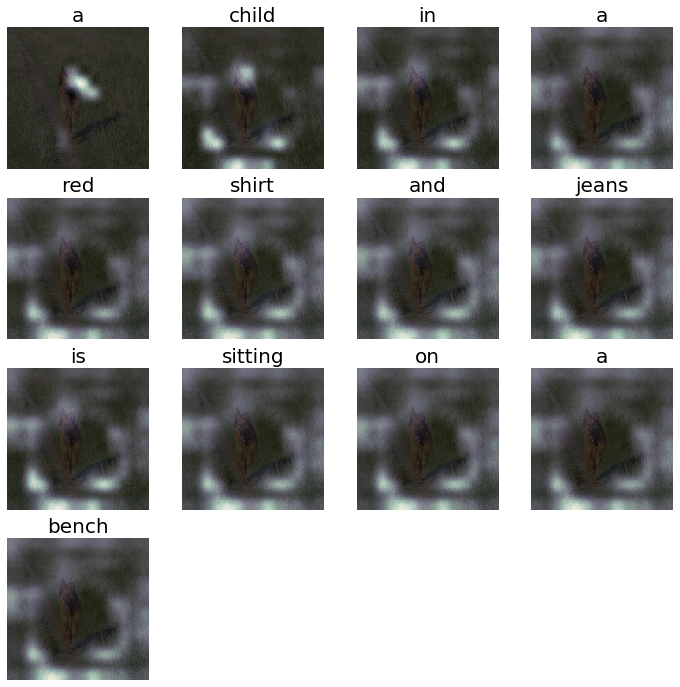

In [11]:
if get_weights:
    cols = 4
    rows = math.ceil(len(best_caption) / cols)
    plt.figure(1, figsize=(12,12))
    for word_num in range(len(best_caption)):
        weights_img = np.reshape(weights[word_num], [14,14])
#        weights_img = misc.imresize(weights_img, (224, 224))
        weights_img = np.array(Image.fromarray(weights_img).resize((224,224)))
        img = image_preprocessing.image_preprocessing(path0, (224,224))
        plt.subplot(rows, cols, word_num + 1)
        plt.title(best_caption[word_num], fontsize=20)
        plt.imshow(img)
        plt.imshow(weights_img, cmap='bone', alpha=0.8)
        plt.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.savefig('./test.png')
    plt.show()

In [12]:
captions_file = os.path.join(config.PATH.ANNOTATIONS_PATH, "Flickr8k.token.txt")
test_txt_path = os.path.join(config.PATH.ANNOTATIONS_PATH, "Flickr_8k.testImages.txt")

filenames_with_all_captions = flickr8k_parse.generate_filenames_with_all_captions(captions_file, config.PATH.IMG_PATH)

test_filenames_with_all_captions = flickr8k_parse.generate_set(test_txt_path, 
                                                               filenames_with_all_captions, 
                                                               config.PATH.IMG_PATH)
print("test_filenames_with_all_captions",test_filenames_with_all_captions)
test_captions = flickr8k_parse.make_list_of_captions(test_filenames_with_all_captions)

test_filenames_with_all_captions {'C:/Users/MStopa/ImageCaptioning/datasets/Flickr8k/Images/3385593926_d3e9c21170.jpg': ['The dogs are in the snow in front of a fence .', 'The dogs play on the snow .', 'Two brown dogs playfully fight in the snow .', 'Two brown dogs wrestle in the snow .', 'Two dogs playing in the snow .'], 'C:/Users/MStopa/ImageCaptioning/datasets/Flickr8k/Images/2677656448_6b7e7702af.jpg': ['a brown and white dog swimming towards some in the pool', 'A dog in a swimming pool swims toward sombody we cannot see .', 'A dog swims in a pool near a person .', 'Small dog is paddling through the water in a pool .', 'The small brown and white dog is in the pool .'], 'C:/Users/MStopa/ImageCaptioning/datasets/Flickr8k/Images/311146855_0b65fdb169.jpg': ['A man and a woman in festive costumes dancing .', 'A man and a woman with feathers on her head dance .', 'A man and a woman wearing decorative costumes and dancing in a crowd of onlookers .', 'one performer wearing a feathered hea

In [13]:
text_processing.preprocess_captions(test_captions)

In [14]:
references = []
for list_captions in test_captions:
    reference = []
    for caption in list_captions:
        reference.append(caption.split())
    references.append(reference)

In [15]:
references[0]

[['the',
  'dogs',
  'are',
  'in',
  'the',
  'snow',
  'in',
  'front',
  'of',
  'a',
  'fence'],
 ['the', 'dogs', 'play', 'on', 'the', 'snow'],
 ['two', 'brown', 'dogs', 'playfully', 'fight', 'in', 'the', 'snow'],
 ['two', 'brown', 'dogs', 'wrestle', 'in', 'the', 'snow'],
 ['two', 'dogs', 'playing', 'in', 'the', 'snow']]

In [18]:
if config.ATTENTION:
    transfer_values = np.load('./cnn_features/vgg16_flickr8k_test_attn.npy')
else:
    transfer_values = np.load('./cnn_features/vgg16_flickr8k_test.npy')
    
print("transfer_values.shape",transfer_values.shape)

transfe_values.shape (1000, 14, 14, 512)


i 0 image [[[0.22861314 0.         0.30242202 ... 0.         0.90597624 0.        ]
  [0.29683018 0.         0.21597236 ... 0.         0.6371277  0.        ]
  [0.11373624 0.         0.16003123 ... 0.         0.70186216 0.        ]
  ...
  [0.         0.         0.         ... 0.         1.2579786  0.        ]
  [0.         0.         0.         ... 0.         1.2145054  0.        ]
  [0.         0.         0.         ... 0.         1.0935948  0.        ]]

 [[0.16584313 0.         0.6791385  ... 0.         0.96385616 0.        ]
  [0.28372407 0.         0.6664834  ... 0.         0.6630713  0.        ]
  [0.         0.         0.48512918 ... 0.         0.83884525 0.        ]
  ...
  [0.         0.         0.         ... 0.         1.0888188  0.        ]
  [0.         0.         0.         ... 0.         0.9946185  0.        ]
  [0.         0.         0.         ... 0.         1.0593538  0.        ]]

 [[0.22582698 0.         0.64768666 ... 0.         0.8614753  0.        ]
  [0.3205918

TypeError: Invalid shape (14, 14, 512) for image data

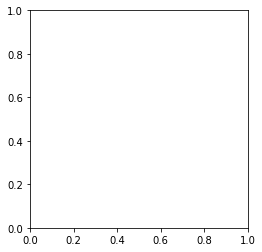

In [17]:
use_transfer_values = True
generated_captions = predict.generate_test_captions(transfer_values, 
                                                    VGG_image_size, 
                                                    decoder_model, 
                                                    VGG_transfer_model, 
                                                    train_vocab, 
                                                    use_transfer_values, 
                                                    beam_size,
                                                    config.DECODER.MAX_LEN,
                                                    config.ATTENTION, 
                                                    False)
print("generated_captions",generated_captions)

In [18]:
print("captions_path",captions_path)
with open(captions_path, 'w') as captions_file:
    for caption in generated_captions:
        captions_file.write(" ".join(caption))
        captions_file.write("\n")

captions_path ./model_files/captions/VGG16_LSTM_Flickr8k_2l_32b_bn_dr_attn_bahdanau_3b.txt


In [19]:
# BLEU score often quoted as a zero to one scale. There is a factor of 100 in these
# expressions so I think that is why they are 0 to 100 here; even though the
# factor multiplies the weights - probably the same effect.
print('BLEU-1 Score on test data: {:.3f}'.format(corpus_bleu(references, generated_captions, weights=(1,0,0,0)) * 100))

BLEU-1 Score on test data: 50.346


In [20]:
print('BLEU-2 Score on test data: {:.3f}'.format(corpus_bleu(references, generated_captions, weights=(0.5,0.5)) * 100))

BLEU-2 Score on test data: 31.962


In [21]:
print('BLEU-3 Score on test data: {:.3f}'.format(corpus_bleu(references, generated_captions, weights=(0.33,0.33,0.33,0)) * 100))

BLEU-3 Score on test data: 20.435


In [22]:
print('BLEU-4 Score on test data: {:.3f}'.format(corpus_bleu(references, generated_captions, weights=(0.25,0.25,0.25,0.25)) * 100))

BLEU-4 Score on test data: 12.889
